In [ ]:
#@title Installing the Dependencies
!pip install mne
import mne
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
file = "drive//MyDrive//RAW//edf_export//data.edf"
data = mne.io.read_raw_edf(file) #filetered eeg loading using the 3rd party libararies
#

info = data.info
channels = data.ch_names
size = os.path.getsize(file)
data

Extracting EDF parameters from /content/drive/MyDrive/RAW/edf_export/data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<RawEDF | data.edf, 6 x 128750 (1030.0 s), ~11 kB, data not loaded>

In [ ]:
channels

['ch1_LF5-FpZ',
 'ch2_OTE_L-FpZ',
 'ch3_BE_L-FpZ',
 'ch4_RF6-FpZ',
 'ch5_OTE_R-FpZ',
 'ch6_BE_R-FpZ']

Effective window size : 2.048 (s)


<ipython-input-5-8d6ea3507856>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data.compute_psd(fmax=60).plot()


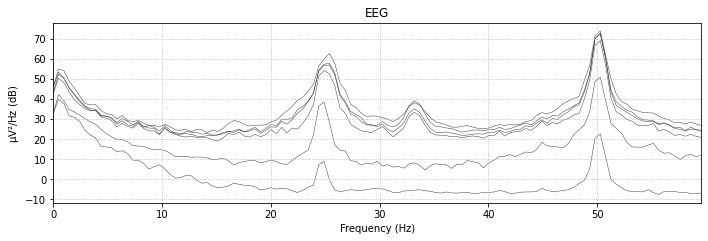

In [ ]:
#@title PSD of the EEG signal
data.compute_psd(fmax=60).plot()

# **ABOVE DATA IS FILTERED BY THE POLYMAN SOFTWARE FOR VISUALISING PURPOSE**

IMPLEMENTATION IN GOLOMB RICE CODE

In [ ]:
EEG_raw_data = data.get_data()
SCALE=1e3
raw_data= EEG_raw_data*SCALE
MAX_LENGTH=10000
DATA_OFFSET=2000;     # data offset
N_HIST_BIN=100

#EEG channel 1
channel_id=0

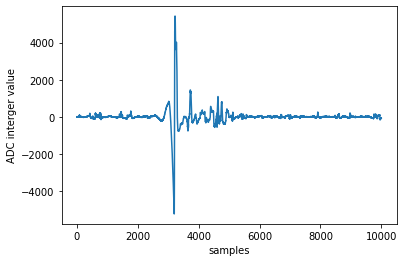

80104


In [ ]:
channel_id = 3
EEG_MAX=0.01;         #  asummed max value of EEG signal
EEG_MAX_INT=2^23-1    # using 24 bit ADC, the max value of EEG is corresponding to 2^23-1

x=np.round(raw_data[channel_id,DATA_OFFSET:DATA_OFFSET-1+MAX_LENGTH]/EEG_MAX*(2^23-1))
plt.plot(x)
plt.ylabel("ADC interger value")

plt.xlabel("samples")
plt.show()
import sys
print(sys.getsizeof(x))

**Golomb Code**

In [ ]:
# Golomb Code
# channel 2 and 5 are not used
# start compression
#Preparation


N= 500    # number of parameters;
b=10   # golomb parameter
M=math.pow(2,b)   #1024= 2^10      # Golomb parameter
codeStream=""
codeStream_debug=""
#Step 1: calculate the differential
y=x[0:N-1]-x[1:N]                     #if we comment this line we can get the raw singals
z=[0]*N
r=[0]*N
q=[0]*N
# Step 2: Convert to all positive values
for k in range (N-1):
    if y[k]>=0 :
        z[k]=2*y[k]
    else :
        z[k]=-2*y[k]-1
    # Step 3: Golomb code

    #def golomb(codeword,m):
    c = int(math.ceil(math.log(M,2)))  # for the formulas refer wikipedia page link in the readme file
    #calculate quotient, remainder
    r[k] = int(z[k]%M)
    q[k] = int(math.floor(z[k]/M))

    div = int(math.pow(2,c)-M)

    #Step 4.1: quotient is put in unary code
    quotientBit = ""
    remainderBit=""
    a=""
    for i in range(q[k]):
        quotientBit = quotientBit + "1"
    quotientBit = quotientBit + "0"
    #     print("First:",first)
    #Step 4.2: remainder is in binary mode
    if r[k] < div:
        b = c-1
        a = "{0:0" + str(b) + "b}"
        #print("1",a.format(r[k]))
        remainderBit = a.format(r[k])
    else:
        b = c
        a = "{0:0" + str(b) + "b}"
        #print("2",a.format(r[k] + div))
        remainderBit = a.format(r[k] + div)

    codeStream_debug = codeStream_debug + quotientBit + "."+ remainderBit +"|"
    codeStream = codeStream + quotientBit + remainderBit


# **Decompression**

In [ ]:
Q_read = 1
R_read = 0

q_part = ""
r_part = ""

q_val = []
r_val = []


counter = 10 #this is the golomb remainder parametere which is the lenght of the remainder

for i in codeStream:
  if (Q_read == 1 and i == '1'):
    q_part = q_part + '1'
  if (Q_read == 1 and i == '0'):
    q_val.append(q_part)
    q_part = ""
    # q_part = q_part + '0'
    # q_val.append(q_part)
    R_read = 1
    Q_read = 0
    continue
  if (R_read and counter >0):
    r_part = r_part + i
    counter = counter -1
    if (counter ==0):
      r_val.append(r_part)
      r_part = ""
      R_read = 0
      Q_read = 1
      counter = 10 ## again ssetting it to the proper value (remainder this values setting must be done properly otherwise results would be fatal)

In [ ]:
print(codeStream_debug)
print(q_val)
print(r_val)

0.0000001111|0.0000100100|0.0000000011|0.0000001111|0.0000000000|0.0000001111|0.0000010110|0.0000000000|0.0000000011|0.0000001000|0.0000001111|0.0000100000|0.0000000011|0.0000010011|0.0000000100|0.0000010111|0.0000100100|0.0000000111|0.0000001001|0.0000000000|0.0000001111|0.0000001000|0.0000000111|0.0000000000|0.0000010100|0.0000001011|0.0000010000|0.0000001011|0.0000000100|0.0000000100|0.0000010001|0.0000011000|0.0000000111|0.0000000000|0.0000001100|0.0000010111|0.0000010000|0.0000000011|0.0000000100|0.0000010100|0.0000000111|0.0000000000|0.0000000011|0.0000000010|0.0000000100|0.0000000111|0.0000010000|0.0000000000|0.0000000011|0.0000010000|0.0000000111|0.0000001100|0.0000001111|0.0000000011|0.0000000000|0.0000010101|0.0000010100|0.0000000011|0.0000001100|0.0000000100|0.0000001111|0.0000011100|0.0000001111|0.0000000000|0.0000001000|0.0000101101|0.0000001000|0.0000011111|0.0000100011|0.0000100111|0.0000010111|0.0000000100|0.0000000111|0.0000000000|0.0000000000|0.0000011001|0.0000011010

**Recognising NULL values as 0s**

In [ ]:
for i in range(len(q_val)):
  if (q_val[i] == ''):
    q_val[i] = '0'

print(q_val)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

**Q values in Decimals**

In [ ]:
from re import template
Q_vals_Decimals = []
for i in q_val:
  if (i == '0'):
    Q_vals_Decimals.append(0)
  else:
    Q_vals_Decimals.append(len(i))

print(Q_vals_Decimals)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**Conversion of r[k] from bits to decimals**

In [ ]:
r_val_Decimal = []
for i in r_val:
  r_val_Decimal.append(int(i,2))

print(r_val_Decimal)

[15, 36, 3, 15, 0, 15, 22, 0, 3, 8, 15, 32, 3, 19, 4, 23, 36, 7, 9, 0, 15, 8, 7, 0, 20, 11, 16, 11, 4, 4, 17, 24, 7, 0, 12, 23, 16, 3, 4, 20, 7, 0, 3, 2, 4, 7, 16, 0, 3, 16, 7, 12, 15, 3, 0, 21, 20, 3, 12, 4, 15, 28, 15, 0, 8, 45, 8, 31, 35, 39, 23, 4, 7, 0, 0, 25, 26, 13, 4, 0, 15, 16, 15, 12, 16, 19, 2, 3, 12, 8, 27, 20, 11, 48, 24, 34, 44, 36, 11, 0, 15, 16, 11, 5, 8, 27, 28, 3, 0, 0, 19, 38, 11, 4, 3, 7, 12, 7, 4, 6, 15, 12, 3, 0, 16, 23, 22, 7, 0, 3, 7, 16, 3, 13, 4, 11, 8, 15, 2, 3, 19, 32, 3, 0, 11, 13, 16, 0, 12, 3, 11, 18, 3, 4, 12, 0, 16, 17, 24, 0, 23, 20, 5, 16, 8, 15, 12, 9, 8, 0, 23, 28, 5, 12, 4, 19, 16, 1, 8, 3, 19, 16, 10, 7, 3, 11, 20, 25, 16, 3, 3, 10, 0, 16, 3, 11, 14, 11, 12, 8, 17, 8, 19, 12, 1, 7, 28, 15, 1, 12, 7, 12, 13, 8, 3, 11, 22, 7, 8, 5, 7, 4, 3, 6, 3, 3, 10, 3, 8, 3, 5, 4, 19, 20, 1, 7, 8, 5, 12, 7, 17, 12, 11, 10, 3, 7, 18, 19, 16, 9, 0, 0, 1, 8, 12, 21, 4, 11, 18, 3, 15, 2, 11, 26, 4, 15, 6, 0, 12, 5, 11, 14, 11, 8, 9, 3, 8, 13, 16, 6, 19, 6, 3, 16, 5,

In [ ]:
decompressed_data = []
for i in range(499):
  decompressed_data.append(M * Q_vals_Decimals[i] + r_val_Decimal[i])

print(z)
print(decompressed_data)

[15.0, 36.0, 3.0, 15.0, 0.0, 15.0, 22.0, 0.0, 3.0, 8.0, 15.0, 32.0, 3.0, 19.0, 4.0, 23.0, 36.0, 7.0, 9.0, 0.0, 15.0, 8.0, 7.0, 0.0, 20.0, 11.0, 16.0, 11.0, 4.0, 4.0, 17.0, 24.0, 7.0, 0.0, 12.0, 23.0, 16.0, 3.0, 4.0, 20.0, 7.0, 0.0, 3.0, 2.0, 4.0, 7.0, 16.0, 0.0, 3.0, 16.0, 7.0, 12.0, 15.0, 3.0, 0.0, 21.0, 20.0, 3.0, 12.0, 4.0, 15.0, 28.0, 15.0, 0.0, 8.0, 45.0, 8.0, 31.0, 35.0, 39.0, 23.0, 4.0, 7.0, 0.0, 0.0, 25.0, 26.0, 13.0, 4.0, 0.0, 15.0, 16.0, 15.0, 12.0, 16.0, 19.0, 2.0, 3.0, 12.0, 8.0, 27.0, 20.0, 11.0, 48.0, 24.0, 34.0, 44.0, 36.0, 11.0, 0.0, 15.0, 16.0, 11.0, 5.0, 8.0, 27.0, 28.0, 3.0, 0.0, 0.0, 19.0, 38.0, 11.0, 4.0, 3.0, 7.0, 12.0, 7.0, 4.0, 6.0, 15.0, 12.0, 3.0, 0.0, 16.0, 23.0, 22.0, 7.0, 0.0, 3.0, 7.0, 16.0, 3.0, 13.0, 4.0, 11.0, 8.0, 15.0, 2.0, 3.0, 19.0, 32.0, 3.0, 0.0, 11.0, 13.0, 16.0, 0.0, 12.0, 3.0, 11.0, 18.0, 3.0, 4.0, 12.0, 0.0, 16.0, 17.0, 24.0, 0.0, 23.0, 20.0, 5.0, 16.0, 8.0, 15.0, 12.0, 9.0, 8.0, 0.0, 23.0, 28.0, 5.0, 12.0, 4.0, 19.0, 16.0, 1.0, 8.0, 3.0, 19.0

In [ ]:
for i in range(len(decompressed_data)):
  if (z[i] != decompressed_data[i]):
    print("error")


**Automation Part**


Given µ, the optimum GPO2 code parameter must be in the range [k∗
min(µ), k∗
max(µ)], where

$k_{min}\left ( \mu  \right ) = max\left\{ 0,\left \lfloor log_2\left ( \frac{2}{3} \left ( \mu +1 \right )\right )\right \rfloor\right\}$

and

$k_{max}\left ( \mu  \right ) = max\left\{ 0,\left \lceil log_2\mu \right \rceil\right\}$

above is the paper one's ideal approximation of the golomb parameter k
where mu is the arthmetic average of the data
we will take 2 time stamps to calculate the above function and compress it using the above function and compare

\\\\\
\\
\\
\\

Below shown is the calculation of the K_min and the K_max data

In [ ]:
mean = np.mean(z)
K_min_log_val = math.log2((2/3)*(mean + 1))
K_min = math.floor(K_min_log_val)

K_max_log_val = math.log2(mean)
K_max = math.ceil(mean)

print(f"K_min -{K_min}")
print(f"K_max -{K_max}")

K_min -3
K_max -13


**Compressing through K_min to K_max data**

In [ ]:
code_rates = []
for x in range(K_max):
  b=x
  M=math.pow(2,b)         # Golomb parameter
  codeStream=""
  codeStream_debug=""
  for k in range (N-1):
    # Step 3: Golomb code

    #def golomb(codeword,m):
    c = int(math.ceil(math.log(M,2)))  # for the formulas refer wikipedia page link in the readme file
    #calculate quotient, remainder
    r[k] = int(z[k]%M)
    q[k] = int(math.floor(z[k]/M))

    div = int(math.pow(2,c)-M)

    #Step 4.1: quotient is put in unary code
    quotientBit = ""
    remainderBit=""
    a=""
    for i in range(q[k]):
        quotientBit = quotientBit + "1"
    quotientBit = quotientBit + "0"
    #     print("First:",first)
    #Step 4.2: remainder is in binary mode
    if r[k] < div:
        b = c-1
        a = "{0:0" + str(b) + "b}"
        #print("1",a.format(r[k]))
        remainderBit = a.format(r[k])
    else:
        b = c
        a = "{0:0" + str(b) + "b}"
        #print("2",a.format(r[k] + div))
        remainderBit = a.format(r[k] + div)

    codeStream_debug = codeStream_debug + quotientBit + "."+ remainderBit +"|"
    codeStream = codeStream + quotientBit + remainderBit
  code_rates.append((len(codeStream)+24)/(N*24))

In [ ]:
print(len(code_rates))

13


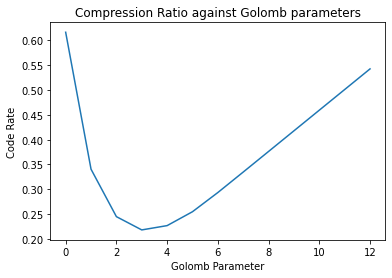

In [ ]:
#@title Plotting
parameters = []
for x in range(K_max):
  parameters.append(x)

f, ax = plt.subplots()
ax.plot(parameters, code_rates)
ax.set_title('Compression Ratio against Golomb parameters')
ax.set_ylabel("Code Rate")
ax.set_xlabel("Golomb Parameter")
plt.show()

In [ ]:
#@title Interactive Plot
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(x= parameters, y=code_rates) )
fig.update_layout(
    title="Compression Ratio against Golomb Parameter",
    xaxis_title="Golomb Parameter",
    yaxis_title="Compression ratio",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.show()

**this interactive plot suggest that the lowest value you can get is 3**